<a href="https://colab.research.google.com/github/DashKarn/Web-scraping-and-analysis/blob/main/V.2%20%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D1%86%D0%B5%D0%BD_%D0%B0%D1%80%D0%B5%D0%BD%D0%B4%D1%8B_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B8%D1%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Подключение библиотек

In [ ]:
import os
import time
from datetime import date
import warnings
import pickle
warnings.filterwarnings("ignore")
import numpy as np
import re
import pandas as pd
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from google.colab import drive, output
drive.mount('/content/gdrive')
drive_data_path = 'gdrive/My Drive/'
output.clear()

# Сбор данных

In [ ]:
def get_page(url):
  try:
    page = requests.get(url)
    page.raise_for_status()
  except Exception as e:
    print(e)
    return None
  else:
    return page

In [ ]:
# берём ссылку на первую страницу предложейний сдачи квартир с браузера и засекаем время исполнения
URL = "https://re.kufar.by/l/minsk/snyat/kvartiru-dolgosrochno?cur=USD"
start_time = time.time()
rent_elements = []
scrab_error = False

# формирует сет со ссылками на описание каждого предложения во избежание повторов
elements_ref_set = set()
# получаем html страницы и находим класс, содержащий количество страниц в предложениях
page = get_page(URL)
if page:
  soup = BeautifulSoup(page.content, "html.parser")
  try:
    class_name = soup.find("span", string='...')['class'][0]
    n_pages = int(soup.find_all("a", class_=class_name)[-2].text)
    print(n_pages)
  except Exception:
    print('Bad number of pages')
    n_pages = '0'
  URL_page = URL

  # цикл по страницам сайта
  for i in range(n_pages):
    if scrab_error:
      break
    output.clear()
    print("Page ", i+1, "/", int(n_pages))
    print("Page ", URL_page)

    # получаем html страницы с предложениями, на ней находим ссылку на следующую страницу, которая отображается стрелочкой "дальше"
    page = get_page(URL_page)
    if not page:
      scrab_error = True
    soup = BeautifulSoup(page.content, "html.parser")
    try:
      class_name = soup.find("span", string='...')['class'][0]      
      next_page = soup.find_all("a", class_=class_name)[-1].get('href')
    except Exception:
      print('Bad next page', i+1)
      break
    URL_page = "https://re.kufar.by" + next_page

    # циклом проходим по каждому элементу на странице
    if not soup.find("section"):
      print('Cannot find elements on page')
      scrab_error = True
      break

    for element in soup.find_all("section"):

      # получам ссылку на страницу с описанием элемента, проверяем, встречалась ли она раньше
      element_ref=element.find('a').get('href')
      if element_ref in elements_ref_set:
        continue
      elements_ref_set.add(element_ref)
      element_page = get_page(element_ref)
      element_soup = BeautifulSoup(element_page.content, "html.parser")
      
      # формируется словарь "название описания" : "значение", для каждого элемента он получатся немного разный
      feats_dict = dict()  
      feats_dict['URL'] = element_ref
      feats_dict['Date'] = date.today().strftime("%d/%m/%Y")
      # практически всё описание предложения содержится в таблице с 2 классами
      description_class = element_soup.find("div", {'data-name':"parameters-block"}).find_all('div')[1]['class']
      if not element_soup.find_all("div", class_=description_class):
        print('Cannot find info element')
        scrab_error = True
        break

      for feat in element_soup.find_all("div", class_=description_class):
        key, value = feat.find_all('div')
        if not key or not value:
          print('Cannot find table description element')
          scrab_error = True
          break
        else:
          feats_dict[key.text] = value.text      

      # добавляем дополнительное описание из других классов-элементов страницы
      if element_soup.find("div", itemprop='description'):
        feats_dict["Описание"] = element_soup.find("div", itemprop='description').text
      else:
        print('Cannot find description')
        scrab_error = True
        break
      # добавляем цену
      if element_soup.find("span", {"data-name":"additional-price"}):
        feats_dict["Цена $"] = element_soup.find("span", {"data-name":"additional-price"}).text
      elif element_soup.find("span", string="Договорная" ):
        feats_dict["Цена $"] = "Договорная"
      elif element_soup.find("span", string="Бесплатно" ):
        feats_dict["Цена $"] = "Бесплатно"
      else:
        print('Cannot find cost')
        scrab_error = True
        break
      # добавляем количество фото
      if element_soup.find("div", {'data-name':"gallery-slide"}):
        feats_dict["Количество фото"] = len(element_soup.find_all("div", {'data-name':"gallery-slide"})) 
      elif element_soup.find("span", string='Нет фото'):
        feats_dict["Количество фото"] = 0
      else:
        print('Cannot find photo')
        scrab_error = True
        break

      rent_elements.append(feats_dict)  

    # после каждой страницы обновляем сохранённый датасет
    new_df = pd.DataFrame(rent_elements)
    try:
      old_df = pd.read_csv(drive_data_path+'Rent_raw.csv', index_col=0)
    except Exception:
      print("File doesn't exist")
      concat_df = new_df
    else:
      concat_df = pd.concat([new_df, old_df[~old_df['URL'].isin(new_df['URL'])].dropna(how='all')]).reset_index(drop=True)  
      print("File exists")
    concat_df.to_csv(drive_data_path+'Rent_raw.csv')
    print("Saved")

if scrab_error:
  print('Something wrong')
print("Elements:", len(rent_elements))
time_delta = time.time() - start_time
if rent_elements:
  print(time_delta//60, "m", round(time_delta % 60), "s ----", round(time_delta/len(rent_elements), 1), "s per element")


In [ ]:
new_df = pd.DataFrame(rent_elements)
try:
  old_df = pd.read_csv(drive_data_path+'Rent_raw.csv', index_col=0)
except Exception:
  print("File doesn't exist")
  concat_df = new_df
else:
  concat_df = pd.concat([new_df, old_df[~old_df['URL'].isin(new_df['URL'])].dropna(how='all')]).reset_index(drop=True)  
  print("File exists")
concat_df.to_csv(drive_data_path+'Rent_raw.csv')
print("Saved")

# Предобработка данных

In [ ]:
df = pd.read_csv(drive_data_path+'Rent_raw.csv', index_col=0)
raw_df_size = len(df)
print(df.shape)
df.head()

(5847, 37)


,URL,Возможна рассрочка,Город / Район,Метро,Количество комнат,Тип аренды,Есть проходная комната,Общая площадь,Студия,Санузел,...,Материал стен,Год постройки,Окна выходят,Обустройство дома,Жилая площадь,Площадь кухни,Кому сдается,Номер и дата договора,Рассрочка от продавца,Товары с доставкой в регионы
0,https://re.kufar.by/vi/minsk/snyat/kvartiru-do...,-,Заводской,Партизанская,2,Долгосрочная,-,45 м²,-,Совмещенный,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://re.kufar.by/vi/minsk/snyat/kvartiru-do...,NaN,Московский,NaN,1,Долгосрочная,NaN,NaN,NaN,Раздельный,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://re.kufar.by/vi/minsk/snyat/kvartiru-do...,NaN,Ленинский,NaN,1,Долгосрочная,NaN,37 м²,NaN,Раздельный,...,Кирпичный,1999,На улицу,"Лифт, Мусоропровод, Домофон",NaN,NaN,NaN,NaN,NaN,NaN
3,https://re.kufar.by/vi/minsk/snyat/kvartiru-do...,NaN,Первомайский,NaN,4,Долгосрочная,Да,60 м²,NaN,Раздельный,...,Панельный,1968,Во двор,Домофон,42 м²,6 м²,"Командировочным, Рабочим",NaN,NaN,NaN
4,https://re.kufar.by/vi/minsk/snyat/kvartiru-do...,NaN,Фрунзенский,NaN,3,Долгосрочная,NaN,90.2 м²,NaN,Раздельный,...,Панельный,2012,NaN,NaN,57.1 м²,11.8 м²,NaN,3/4а от 21.04.2022,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5847 entries, 0 to 5846
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   URL                           5847 non-null   object 
 1   Возможна рассрочка            472 non-null    object 
 2   Город / Район                 5846 non-null   object 
 3   Метро                         2622 non-null   object 
 4   Количество комнат             5844 non-null   object 
 5   Тип аренды                    5847 non-null   object 
 6   Есть проходная комната        1086 non-null   object 
 7   Общая площадь                 4752 non-null   object 
 8   Студия                        953 non-null    object 
 9   Санузел                       5598 non-null   object 
 10  Балкон                        5351 non-null   object 
 11  Ремонт                        4338 non-null   object 
 12  Обустройство быта             4992 non-null   object 
 13  В в

Определяем процент пропущенных значений. В некоторых колонках он большой, поэтому эти колонки удаляются.

Процент одинаковых объявлений без колонки URL 0,034%

In [ ]:
missing_val = pd.DataFrame(df.isnull().sum())
missing_val = missing_val.reset_index()
missing_val.columns = ['Feature', '% nans']
missing_val['Dtype'] = df.dtypes.values
missing_val['% nans'] = round(missing_val['% nans']*100/len(df), 1)
print(df.drop(columns='URL').duplicated().value_counts(normalize=True))
df.drop_duplicates(df.columns[1:], inplace=True)
missing_val.sort_values('% nans', ascending=False)

False    0.999658
True     0.000342
dtype: float64


,Feature,% nans,Dtype
36,Товары с доставкой в регионы,100.0,object
35,Рассрочка от продавца,99.1,object
1,Возможна рассрочка,91.9,object
21,Возможен обмен,88.8,object
15,Без мебели,86.3,object
8,Студия,83.7,object
19,В новостройке,82.8,object
6,Есть проходная комната,81.4,object
34,Номер и дата договора,80.3,object
33,Кому сдается,63.9,object


In [ ]:
def get_number(s):
  n = re.findall(r'\d+', str(s).replace(" ", ""))
  if n:
    return int(n[0])
  else:
    return np.nan

Перевод признаков в надлежащий формат и фильтрация

In [ ]:
df = pd.read_csv(drive_data_path+'Rent_raw.csv', index_col=0)

# перевод описаний из строки в число, нечисленные значения заменяются NaN 
df["Цена $"] = df["Цена $"].apply(get_number)
df = df[df["Цена $"]<5000]
df["Общая площадь"] = df["Общая площадь"].apply(get_number)
df["Жилая площадь"] = df["Жилая площадь"].apply(get_number)
df["Площадь кухни"] = df["Площадь кухни"].apply(get_number)
df["Количество комнат"] = df["Количество комнат"].apply(get_number)
df.loc[df["Студия"] == "Да", 'Количество комнат'] = 1

# перевод признаков в бинарное представление
df['Агенство'] = df['Номер и дата договора'].apply(lambda x: 1 if not pd.isnull(x) else 0)
df["Студия"].replace({"Да": 1, "-": 0, np.nan: 0}, inplace=True)
df["Без мебели"].replace({"Да": 1, "-": 0, np.nan: 0}, inplace=True)
df["Состояние"].replace({"Вторичное жилье": 0, "Новое": 1, np.nan: 0}, inplace=True)

# перевод признаков в число
df["Количество фото"] = df["Количество фото"].apply(lambda x: x.split('/')[1] if '/' in x else x).astype(int)
df["Этажность дома"] = pd.to_numeric(df["Этажность дома"], errors='coerce', downcast="integer")
df["Этаж"] = pd.to_numeric(df["Этаж"], errors='coerce', downcast="integer")
df["Возраст дома"] = 2022 - pd.to_numeric(df["Год постройки"], errors='coerce')

df["В новостройке"].replace({"Да": 1, "-": 0, np.nan: 0}, inplace=True)
df.loc[df["Возраст дома"]<10, "В новостройке"] = 1

# перевод признаков в категориальные с заменой значений
df["Ремонт"].replace({'Строительная отделка': 'Без отделки'}, inplace=True)
df["Санузел"].replace({np.nan:"Раздельный"}, inplace=True)
df["Балкон"].replace({"Лоджия": 1, "Да": 1, "Есть": 1, 'Один':1, "Два":2, 'Нет':0, np.nan: 0}, inplace=True)
df["Предоплата"].replace({"Месяц": 1, "2 месяца": 2, "3 месяца": 3, "Полгода": 6, 
                          "Залог": 1, "Нет": 0,  np.nan: 0}, inplace=True)

# удаление строк с пропущенными значениями в важных признаках
df.dropna(subset=['Город / Район', "Цена $", "Количество комнат", "Количество фото"], inplace=True)

# выбор необходимых колонок
df = df[['Город / Район', 'Метро', 'Количество комнат',
         'Общая площадь', "Жилая площадь", "Площадь кухни", 'Санузел', 'Ремонт', 'Обустройство быта', 
         'В ванной', 'На кухне', 'Предоплата', 'Этаж', 'Этажность дома', 'Обустройство дома',
         'В новостройке', 'Состояние', 'Цена $', 'Количество фото',
         'Балкон', 'Микрорайон', 'Без мебели', 'Агенство']]

df.head()

,Город / Район,Метро,Количество комнат,Общая площадь,Жилая площадь,Площадь кухни,Санузел,Ремонт,Обустройство быта,В ванной,...,Этажность дома,Обустройство дома,В новостройке,Состояние,Цена $,Количество фото,Балкон,Микрорайон,Без мебели,Агенство
0,Заводской,Партизанская,2.0,45.0,NaN,NaN,Совмещенный,Косметический,"Wi-Fi, Телевизор, Телефон, Мебель","Стиральная машина, Комплект полотенец",...,5.0,NaN,0,0,235.0,9,0,NaN,0,0
1,Московский,NaN,1.0,NaN,NaN,NaN,Раздельный,Косметический,NaN,NaN,...,9.0,NaN,0,0,154.0,6,1,Малиновка,1,0
2,Ленинский,NaN,1.0,37.0,NaN,NaN,Раздельный,Косметический,Мебель,Стиральная машина,...,14.0,"Лифт, Мусоропровод, Домофон",0,0,200.0,9,1,NaN,0,0
3,Первомайский,NaN,4.0,60.0,42.0,6.0,Раздельный,Косметический,"Мебель, Телефон, Телевизор, Wi-Fi",Стиральная машина,...,5.0,Домофон,0,0,380.0,10,1,Зеленый луг,0,0
4,Фрунзенский,NaN,3.0,90.0,57.0,11.0,Раздельный,Евро,"Wi-Fi, Мебель, Телевизор","Душевая кабина, Стиральная машина",...,9.0,NaN,0,0,580.0,15,1,Кунцевщина,0,1


Некоторые колонки содержат список атрибутов, поэтому их презобразуем в отдельные колонки

In [ ]:
complex_columns = ["Обустройство быта", "На кухне", "В ванной", "Обустройство дома"]
for col in complex_columns:
  print(df[col].str.split(", ").explode().unique())

['Wi-Fi' 'Телевизор' 'Телефон' 'Мебель' nan 'Утюг' 'Кондиционер']
['Холодильник' 'Посуда/столовые приборы' 'Газовая плита' nan 'СВЧ-печь'
 'Электрическая плита' 'Посудомоечная машина' 'Кофеварка']
['Стиральная машина' 'Комплект полотенец' nan 'Душевая кабина' 'Джакузи'
 'Фен']
[nan 'Лифт' 'Мусоропровод' 'Домофон' 'Пандус' 'Стояночное место'
 'Парковка крытая' 'Подвал' 'Огороженная территория' 'Видеонаблюдение']


In [ ]:
old_columns = set(df.columns)
for col in complex_columns:
  df = df.join(pd.get_dummies(df[col].str.split(", ").explode()).sum(level=0))
equipment_columns = set(df.columns) - old_columns
equipment_columns.add("Без мебели")
df.drop(columns=complex_columns, inplace=True)
df.head()

,Город / Район,Метро,Количество комнат,Общая площадь,Жилая площадь,Площадь кухни,Санузел,Ремонт,Предоплата,Этаж,...,Фен,Видеонаблюдение,Домофон,Лифт,Мусоропровод,Огороженная территория,Пандус,Парковка крытая,Подвал,Стояночное место
0,Заводской,Партизанская,2.0,45.0,NaN,NaN,Совмещенный,Косметический,1,1.0,...,0,0,0,0,0,0,0,0,0,0
1,Московский,NaN,1.0,NaN,NaN,NaN,Раздельный,Косметический,0,9.0,...,0,0,0,0,0,0,0,0,0,0
2,Ленинский,NaN,1.0,37.0,NaN,NaN,Раздельный,Косметический,1,7.0,...,0,0,1,1,1,0,0,0,0,0
3,Первомайский,NaN,4.0,60.0,42.0,6.0,Раздельный,Косметический,0,3.0,...,0,0,1,0,0,0,0,0,0,0
4,Фрунзенский,NaN,3.0,90.0,57.0,11.0,Раздельный,Евро,0,3.0,...,0,0,0,0,0,0,0,0,0,0


В цене наблюдаются выбросы, которые нельзя предсказать, поэтому можно обрезать допустимый интервал значений до 1000 

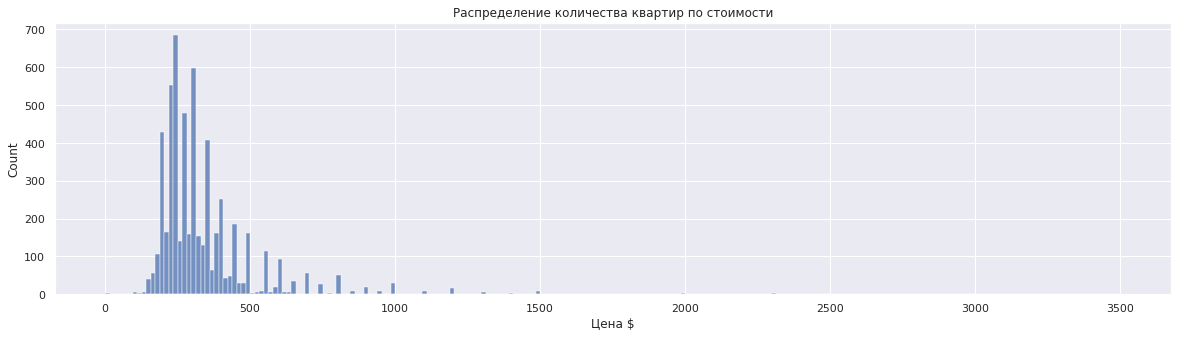

63 квартиры стоимостью выше 1000 $, это 1.5 %
5693 квартир всего


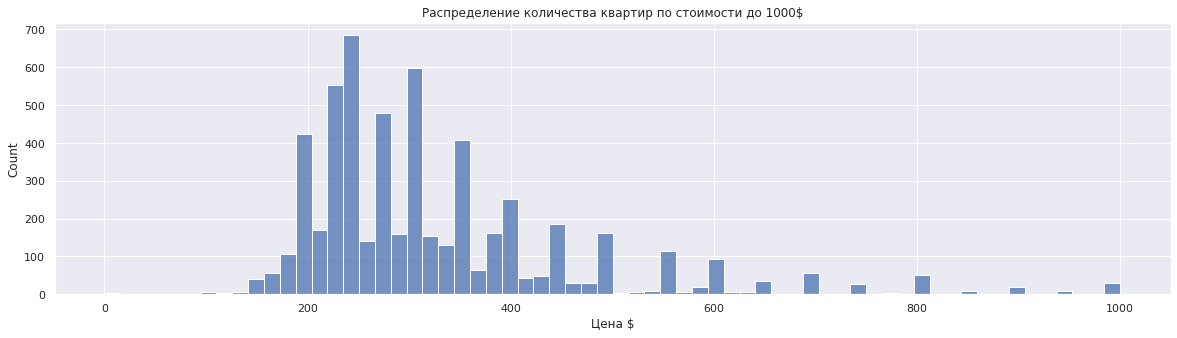

In [ ]:
sns.set(rc={'figure.figsize':(20,5)})
plt.title("Распределение количества квартир по стоимости")
sns.histplot(df, x='Цена $')
plt.show()

max_cost = 1000
min_cost = 50
print(len(df[df['Цена $']>max_cost]), "квартиры стоимостью выше", max_cost, "$, это", round(len(df[df['Цена $']>=max_cost])/len(df)*100, 1) , "%")
print(len(df), "квартир всего")

plt.title("Распределение количества квартир по стоимости до "+ str(max_cost)+ "$")
sns.histplot(df[df['Цена $']<=max_cost], x='Цена $')
plt.show()

df = df[df['Цена $']<=max_cost]
df = df[df['Цена $']>min_cost]

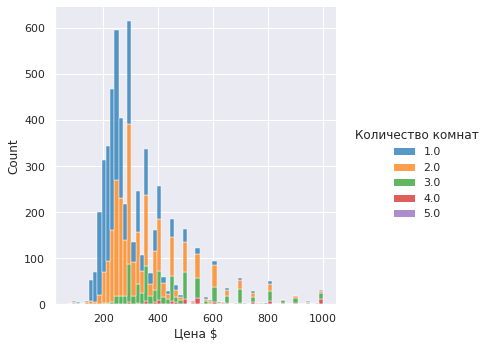

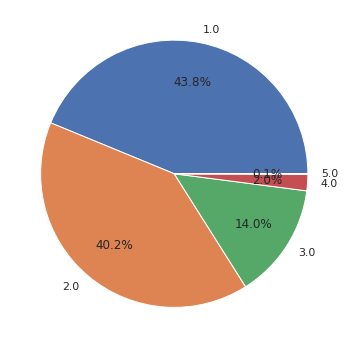

In [ ]:
sns.displot(data=df, x="Цена $", hue="Количество комнат", multiple="stack", palette="tab10")
plt.show()
s = df["Количество комнат"].value_counts(sort=False).sort_index()
pct = '%1.1f%%'
plt.pie(s.values, labels=s.index, autopct=pct, pctdistance=0.7) 
plt.show()

Вручную зададим ограничения на площадь

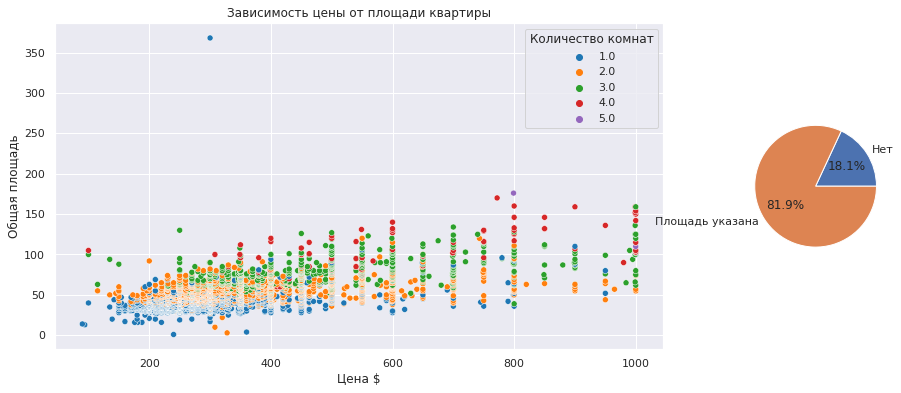

In [ ]:
sorted_df = df.sort_values('Общая площадь')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [4, 1]})
ax1.set_title("Зависимость цены от площади квартиры")
sns.scatterplot(data=sorted_df, x="Цена $", y="Общая площадь", hue="Количество комнат", ax=ax1, palette="tab10")
ax2.pie([df['Общая площадь'].isna().sum(), df['Общая площадь'].count()], labels=['Нет', 'Площадь указана'], autopct='%1.1f%%') 
plt.show()

df.drop(df[df['Общая площадь'] >200].index, inplace=True)

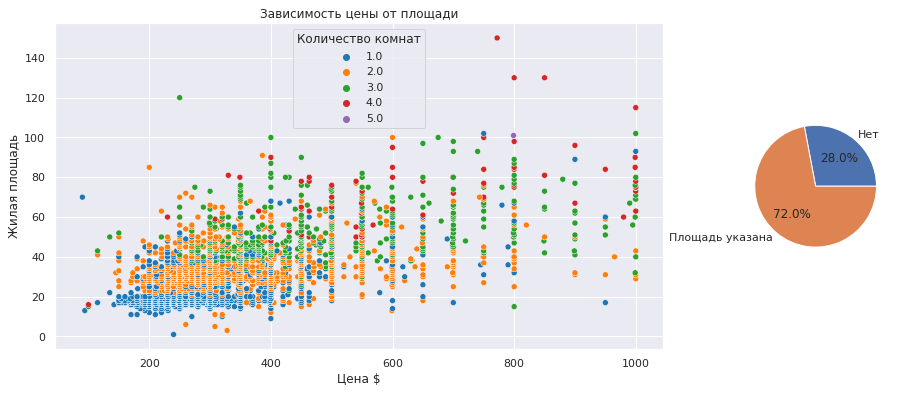

In [ ]:
sorted_df = df.sort_values('Жилая площадь')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [4, 1]})
ax1.set_title("Зависимость цены от площади")
sns.scatterplot(data=sorted_df, x="Цена $", y="Жилая площадь", hue="Количество комнат", ax=ax1, palette="tab10")
ax2.pie([df['Жилая площадь'].isna().sum(), df['Жилая площадь'].count()], labels=['Нет', 'Площадь указана'], autopct='%1.1f%%') 
plt.show()

df.drop(df[df['Жилая площадь'] >120].index, inplace=True)

Обрезаем максимальное значение количества фотографий

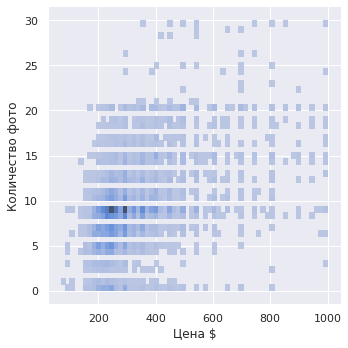

In [ ]:
sns.set(rc={'figure.figsize':(10,6)})
sns.displot(data=df.sort_values("Количество фото"), x="Цена $", y="Количество фото")
df.loc[df["Количество фото"] > 20, 'Количество фото'] = 21

Количество потерь после очистки датасета почти 4%, что очень хорошо, т.к. не потеряли необхдимые данные

In [ ]:
print("После очистки датасета было удалено", round((raw_df_size - len(df))/raw_df_size*100, 1),"% записей")

После очистки датасета было удалено 3.8 % записей


Проверяем корреляцию признаков. Ожидаемо, разные типы площади коррелирует между собой, в итоге будет отобран только необходимый тип.

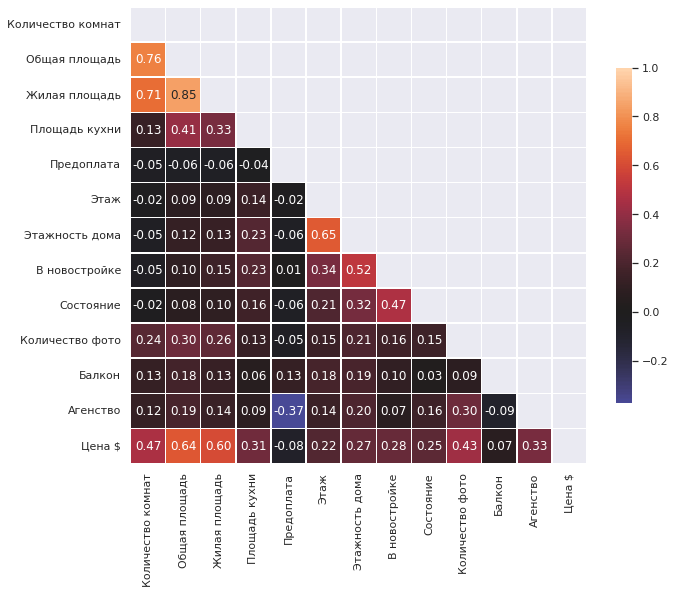

In [ ]:
cols = list(df.drop(columns=['Цена $', *equipment_columns]).columns)
cols.append('Цена $')
corr_matrix = df[cols].corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    corr_matrix,
    mask=mask,
    vmax=1,
    center=0,
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
);

Заново проверяем количество пропущенных значений для выбора стратегии работы с ними.

In [ ]:
missing_val = pd.DataFrame(df.isna().sum())
missing_val = missing_val.reset_index()
missing_val.columns = ['Feature', 'N nans']
missing_val['Dtype'] = df.dtypes.values
missing_val['% nans'] = round(missing_val['N nans']*100/len(df), 3)
missing_val[missing_val['N nans']>0].sort_values('% nans', ascending=False)

,Feature,N nans,Dtype,% nans
1,Метро,3104,object,55.212
16,Микрорайон,2197,object,39.079
5,Площадь кухни,1924,float64,34.223
4,Жилая площадь,1573,float64,27.979
7,Ремонт,1421,object,25.276
3,Общая площадь,1017,float64,18.090
10,Этажность дома,708,float64,12.593
9,Этаж,416,float64,7.400


In [ ]:
# пропущенные значения в непрерывных атрибутах площади заполняются средними значениями площадей в зависимости от количества комнат
filled_df = df.copy()
filled_df["Общая площадь"] = filled_df["Общая площадь"].fillna(filled_df.groupby('Количество комнат')['Общая площадь'].transform('mean'))
filled_df["Площадь кухни"] = filled_df["Площадь кухни"].fillna(filled_df.groupby('Количество комнат')['Площадь кухни'].transform('mean'))
filled_df["Жилая площадь"] = filled_df["Жилая площадь"].fillna(filled_df.groupby('Количество комнат')['Жилая площадь'].transform('mean'))
# пропущенные значения в непрерывных атрибутах этажности и этажа заполняются средними значениями
filled_df['Этаж'].fillna(filled_df['Этаж'].mean(), inplace=True)
filled_df['Этажность дома'].fillna(filled_df['Этажность дома'].mean(), inplace=True)
# категориальные признаки пребразуются методом One-hot-encoding, где NaN соответствует 0
cat_columns = ['Ремонт', 'Санузел', 'Город / Район', 'Микрорайон', 'Метро']
filled_df = filled_df.join(pd.get_dummies(filled_df[cat_columns], dummy_na=True, drop_first=True)).drop(columns=cat_columns)

In [ ]:
np.sum(filled_df.isna())

Количество комнат         0
Общая площадь             0
Жилая площадь             0
Площадь кухни             0
Предоплата                0
                         ..
Метро_Спортивная          0
Метро_Тракторный завод    0
Метро_Уручье              0
Метро_Фрунзенская         0
Метро_nan                 0
Length: 140, dtype: int64

#Предсказание

Создание датасета и колонки целевых значений.

Нормализация значений.


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate

y = filled_df['Цена $']
X = filled_df.drop(columns=['Цена $'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Определение метрик для оценки модели

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

def get_cv_error(scores):
   return {'cv_mae': abs(np.mean(scores['test_neg_mean_absolute_error'])),
           'cv_mse': abs(np.mean(scores['test_neg_mean_squared_error'])),
           'cv_rmse':abs(np.mean(scores['test_neg_root_mean_squared_error']))}

Выбор различных алгоритмов и их тестирование методом кросс-валидации.

In [ ]:
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, BayesianRidge
from sklearn.ensemble import  RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

regressors = [XGBRegressor(objective ='reg:squarederror'), LinearRegression(), BayesianRidge(), Lasso(alpha=1),  RandomForestRegressor(), 
              SVR(kernel='linear'), SVR(kernel='poly'), SVR(kernel='rbf'), SVR(kernel='sigmoid'), KNeighborsRegressor(n_neighbors=3),
              KNeighborsRegressor(n_neighbors=8), KNeighborsRegressor(n_neighbors=13)]
reg_names = ['XGBRegressor', 'LinearRegression', 'BayesianRidge', 'Lasso',  'RandomForestRegressor',
             'SVR linear', 'SVR polynomial', 'SVR rbf', 'SVR sigmoid','KNeighborsRegressor 3',
             'KNeighborsRegressor 8', 'KNeighborsRegressor 13']
results = []
predictions = []
for regressor, name in zip(regressors, reg_names):
  start_time = time.time()
  scores = cross_validate(regressor, X_scaled, y, scoring=['neg_mean_absolute_error',
                                                'neg_root_mean_squared_error',
                                                'neg_mean_squared_error'], cv=5)
  time_delta = time.time() - start_time
  res = {'Regressor': name, 'Time, ms': round(time_delta, 2)}
  res.update(get_cv_error(scores))
  results.append(res)
result_df = pd.DataFrame(results)
result_df.sort_values('cv_rmse') 

,Regressor,"Time, ms",cv_mae,cv_mse,cv_rmse
0,XGBRegressor,6.20,5.181793e+01,6.280810e+03,7.849614e+01
4,RandomForestRegressor,25.56,5.182931e+01,6.428115e+03,7.930451e+01
2,BayesianRidge,0.60,5.491481e+01,6.669883e+03,8.108081e+01
3,Lasso,0.20,5.483691e+01,6.692888e+03,8.110741e+01
5,SVR linear,12.31,5.385193e+01,7.304428e+03,8.417641e+01
10,KNeighborsRegressor 8,0.82,6.447447e+01,9.755170e+03,9.765392e+01
11,KNeighborsRegressor 13,0.83,6.520591e+01,1.003938e+04,9.903512e+01
9,KNeighborsRegressor 3,0.65,6.667549e+01,1.024346e+04,1.001583e+02
8,SVR sigmoid,15.83,6.403523e+01,1.164804e+04,1.052937e+02
7,SVR rbf,15.03,7.738714e+01,1.608155e+04,1.242520e+02


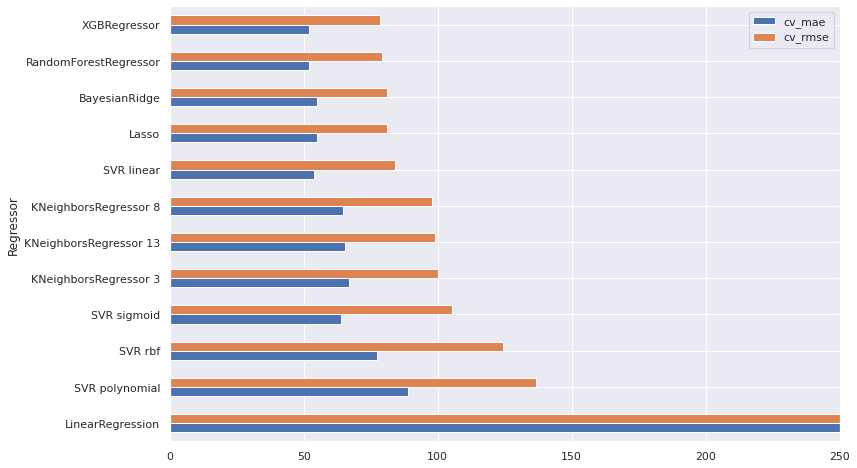

In [ ]:
from matplotlib import rcParams
fig, ax = plt.subplots(1, 1, figsize = (12, 8))
ax.set(xlim=(0, 250))
rcParams.update({'figure.autolayout': True})
result_df[['Regressor', 'cv_mae', 'cv_rmse']].sort_values('cv_rmse', ascending=False).plot.barh(x='Regressor', ax=ax);

Исходя из полученных результатов, наиболее продуктивный алгоритм - XGBRegressor. Он гораздо быстрее случайного леса, хотя их предсказательная способность одинакова.

Можно посмотреть, насколько предсказанные значения отклоняются от реальных. Они должны стремиться к красной линии, и чем больше отклонение от неё по оси У - тем больше ошибка. Алгоритм плохо предсказывает большие значеня исходя из их природы: арендодатель случайно выставляет цену квартиры, не ориентируясь на рынок.

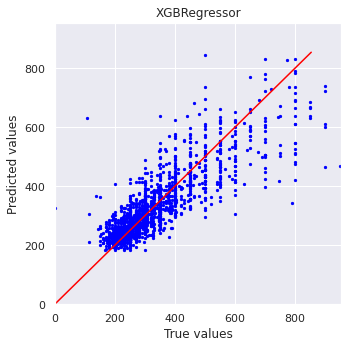

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=5)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

reg = XGBRegressor(objective ='reg:squarederror')
reg.fit(X_train_scaled, y_train)
predictions=reg.predict(X_test_scaled)
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
max_value = max(predictions) + 10
plt.xlim(0, max_value+100)
plt.ylim(0, max_value+100)
plt.title('XGBRegressor')
plt.scatter(y_test, predictions, c='blue',s=5)
plt.plot([0, max_value], [0, max_value], c='red')
plt.ylabel('Predicted values')
plt.xlabel('True values')
plt.show()

Степень важности атрибутов по мнению алгоритма.

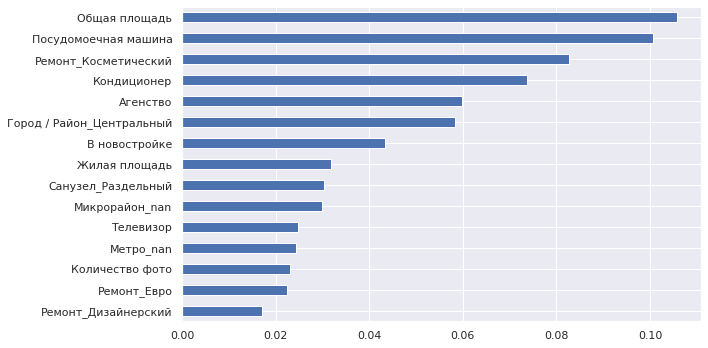

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
feature_importances = pd.Series(reg.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=True, inplace=True)
feature_importances[-15:].plot.barh()

Объективная степень важности атрибутов исходя из влияния погрешности в них на результат.

In [ ]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance
output.clear()

perm = PermutationImportance(reg).fit(X_test_scaled, y_test)
importance = perm.feature_importances_
columns_eli5 = [x for _, x in sorted(zip(importance, X.columns), key=lambda pair: pair[0], reverse=True)]

eli5.show_weights(perm, feature_names=X.columns.tolist())

Weight,Feature
0.2054 ± 0.0182,Общая площадь
0.0607 ± 0.0158,Агенство
0.0606 ± 0.0094,Жилая площадь
0.0247 ± 0.0097,Количество фото
0.0182 ± 0.0055,Город / Район_Центральный
0.0182 ± 0.0049,Метро_nan
0.0167 ± 0.0054,Ремонт_Косметический
0.0149 ± 0.0040,Посудомоечная машина
0.0127 ± 0.0026,В новостройке
0.0126 ± 0.0018,Санузел_Раздельный


Уменьшение числа атрибутов не влияет положительно на результат, также не ускоряет значительно алгоритм. Поэтому сокращение атрибутов не нужно.

In [ ]:
print('All columns', len(X.columns))
regressor = XGBRegressor(objective ='reg:squarederror')
reg_columns = [X.columns, feature_importances.index[:50], columns_eli5[:25],columns_eli5[:50], feature_importances.index[:100], columns_eli5[:100]]
reg_columns_names = ['All', "Regressor 50", "eli5 50", "Regressor 100", "eli5 100"]
results = []
predictions = []
for reg_cols, name in zip(reg_columns, reg_columns_names):
  start_time = time.time()
  X_scaled = scaler.fit_transform(X[reg_cols])
  scores = cross_validate(regressor, X_scaled, y, scoring=['neg_mean_absolute_error',
                                                'neg_root_mean_squared_error',
                                                'neg_mean_squared_error'], cv=5)
  time_delta = time.time() - start_time
  res = {'Columns': name, 'Time, ms': round(time_delta, 2)}
  res.update(get_cv_error(scores))
  results.append(res)
result_df = pd.DataFrame(results)
result_df.sort_values('cv_rmse') 

All columns 140


,Columns,"Time, ms",cv_mae,cv_mse,cv_rmse
3,Regressor 100,6.70,51.784352,6249.318428,78.320160
0,All,8.67,51.840920,6301.131846,78.660447
2,eli5 50,3.27,52.695008,6425.109608,79.437313
4,eli5 100,8.85,80.589637,13891.846013,116.498495
1,Regressor 50,5.29,96.369688,18769.584891,135.705883


Окончательное обучение алгоритма и сохранение для дальнейшего использования

In [ ]:
regressor = XGBRegressor(objective ='reg:squarederror')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
regressor.fit(X_scaled, y)
with open(drive_data_path+'XGBRegressor.pickle', 'wb') as f:
  pickle.dump(regressor, f)
with open(drive_data_path+'Scaler.pickle', 'wb') as f:
  pickle.dump(scaler, f)

# Итоговые функции

In [ ]:
def prepare_data(raw_df):
  df = raw_df.copy()
  df.drop_duplicates(df.columns[1:], inplace=True)
  # перевод описаний из строки в число, нечисленные значения заменяются NaN 
  df["Цена $"] = df["Цена $"].apply(get_number)
  df = df[df["Цена $"]<1000]
  df = df[df["Цена $"]>50]
  df["Общая площадь"] = df["Общая площадь"].apply(get_number)
  df.drop(df[df['Общая площадь'] >200].index, inplace=True)
  df["Жилая площадь"] = df["Жилая площадь"].apply(get_number)
  df.drop(df[df['Жилая площадь'] >120].index, inplace=True)
  df["Площадь кухни"] = df["Площадь кухни"].apply(get_number)
  df["Количество комнат"] = df["Количество комнат"].apply(get_number)
  df = df[df["Количество комнат"]<=5] 
  df = df[df["Количество комнат"]>=0]
  df.loc[df["Студия"] == "Да", 'Количество комнат'] = 1

  # перевод признаков в бинарное представление
  df['Агенство'] = df['Номер и дата договора'].apply(lambda x: 1 if not pd.isnull(x) else 0)
  df["Студия"].replace({"Да": 1, "-": 0, np.nan: 0}, inplace=True)
  df["Без мебели"].replace({"Да": 1, "-": 0, np.nan: 0}, inplace=True)
  df["Состояние"].replace({"Вторичное жилье": 0, "Новое": 1, np.nan: 0}, inplace=True)

  # перевод признаков в число
  df["Количество фото"] = df["Количество фото"].apply(lambda x: x.split('/')[1] if '/' in x else x).astype(int)
  df.loc[df["Количество фото"] > 20, 'Количество фото'] = 21
  df["Этажность дома"] = pd.to_numeric(df["Этажность дома"], errors='coerce', downcast="integer")
  df["Этаж"] = pd.to_numeric(df["Этаж"], errors='coerce', downcast="integer")
  df["Возраст дома"] = 2022 - pd.to_numeric(df["Год постройки"], errors='coerce')

  df["В новостройке"].replace({"Да": 1, "-": 0, np.nan: 0}, inplace=True)
  df.loc[df["Возраст дома"]<10, "В новостройке"] = 1

  # перевод признаков в категориальные с заменой значений
  df["Ремонт"].replace({'Строительная отделка': 'Без отделки'}, inplace=True)
  df["Санузел"].replace({np.nan:"Раздельный"}, inplace=True)
  df["Балкон"].replace({"Лоджия": 1, "Да": 1, "Есть": 1, 'Один':1, "Два":2, 'Нет':0, np.nan: 0}, inplace=True)
  df["Предоплата"].replace({"Месяц": 1, "2 месяца": 2, "3 месяца": 3, "Полгода": 6, 
                            "Залог": 1, "Нет": 0,  np.nan: 0}, inplace=True)

  # удаление строк с пропущенными значениями в важных признаках
  df.dropna(subset=['Город / Район', "Цена $", "Количество комнат", "Количество фото"], inplace=True)

  # выбор необходимых колонок
  df = df[['URL', 'Город / Район', 'Метро', 'Количество комнат',
          'Общая площадь', "Жилая площадь", "Площадь кухни", 'Санузел', 'Ремонт', 'Обустройство быта', 
          'В ванной', 'На кухне', 'Предоплата', 'Этаж', 'Этажность дома', 'Обустройство дома',
          'В новостройке', 'Состояние', 'Цена $', 'Количество фото',
          'Балкон', 'Микрорайон', 'Без мебели', 'Агенство']]

  complex_columns = ["Обустройство быта", "На кухне", "В ванной", "Обустройство дома"]
  old_columns = set(df.columns)
  for col in complex_columns:
    df = df.join(pd.get_dummies(df[col].str.split(", ").explode()).sum(level=0))
  equipment_columns = set(df.columns) - old_columns
  equipment_columns.add("Без мебели")
  df.drop(columns=complex_columns, inplace=True)

  filled_df = df.copy()
  filled_df["Общая площадь"] = filled_df["Общая площадь"].fillna(filled_df.groupby('Количество комнат')['Общая площадь'].transform('mean'))
  filled_df["Площадь кухни"] = filled_df["Площадь кухни"].fillna(filled_df.groupby('Количество комнат')['Площадь кухни'].transform('mean'))
  filled_df["Жилая площадь"] = filled_df["Жилая площадь"].fillna(filled_df.groupby('Количество комнат')['Жилая площадь'].transform('mean'))
  # пропущенные значения в непрерывных атрибутах этажности и этажа заполняются средними значениями
  filled_df['Этаж'].fillna(filled_df['Этаж'].mean(), inplace=True)
  filled_df['Этажность дома'].fillna(filled_df['Этажность дома'].mean(), inplace=True)
  # категориальные признаки пребразуются методом One-hot-encoding, где NaN соответствует 0
  cat_columns = ['Ремонт', 'Санузел', 'Город / Район', 'Микрорайон', 'Метро']
  filled_df = filled_df.join(pd.get_dummies(filled_df[cat_columns], dummy_na=True, drop_first=True)).drop(columns=cat_columns)

  dropped_df = raw_df[raw_df['URL'].isin(filled_df['URL'])]

  return filled_df.drop(columns=['URL']), dropped_df

In [ ]:
def get_predictions(prepared_df):
  with open(drive_data_path+'XGBRegressor.pickle', 'rb') as f:
    regressor = pickle.load(f)
  with open(drive_data_path+'Scaler.pickle', 'rb') as f:
    scaler = pickle.load(f)
  X = prepared_df.drop(columns=['Цена $'])
  X_scaled = scaler.transform(X)
  predictions = regressor.predict(X_scaled)
  return predictions

In [ ]:
def update_regressor(prepared_df):
  with open(drive_data_path+'XGBRegressor.pickle', 'rb') as f:
    regressor = pickle.load(f)
  with open(drive_data_path+'Scaler.pickle', 'rb') as f:
    scaler = pickle.load(f)
  y = prepared_df['Цена $']
  X = prepared_df.drop(columns=['Цена $'])
  scaler.partial_fit(X)
  X_scaled = scaler.transform(X)
  regressor.fit(X_scaled,y)
  with open(drive_data_path+'XGBRegressor.pickle', 'wb') as f:
    pickle.dump(regressor, f)
  with open(drive_data_path+'Scaler.pickle', 'wb') as f:
    pickle.dump(scaler, f)
  return 

def update_scaler(prepared_df):
  with open(drive_data_path+'Scaler.pickle', 'rb') as f:
    scaler = pickle.load(f)
  y = prepared_df['Цена $']
  X = prepared_df.drop(columns=['Цена $'])
  scaler.partial_fit(X)
  X_scaled = scaler.transform(X)
  with open(drive_data_path+'Scaler.pickle', 'wb') as f:
    pickle.dump(scaler, f)
  return 

In [ ]:
df = pd.read_csv(drive_data_path+'Rent_raw.csv', index_col=0)
prepared_df, dropped = prepare_data(df)
predictions = get_predictions(prepared_df)
update_scaler(prepared_df)
update_regressor(prepared_df)